In [1]:
import h5py
import numpy as np    
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

######## Very basic access to the dataset - let's see what we are working with! #######

raw_dataset = h5py.File('C:/Users/Admin/Documents/GitHub/Team_Project_ComputerVision/datasets/climatevisions_2019_popular.h5', 'r+')
dataset = raw_dataset['tweet_data']
image_directory = 'C:\\Users\\Admin\\Documents\\Dataset_small\\'
cols_to_strip = ['created_at', 'img_name', 'language', 'referenced_tweets', 'text', 'tweet_id']   

data_dict = {}
# Iterate through the keys (assuming each key is a column name)
for key in dataset.keys():
     # Access the data for each column
     column_data = dataset[key][:]
        
     # Store the data in the dictionary with the column name as the key
     data_dict[key] = column_data
     
df = pd.DataFrame(data_dict)
df[cols_to_strip] = df[cols_to_strip].astype('string')
df[cols_to_strip] = df[cols_to_strip].replace(to_replace=r'^b\':?(.*)\'$', value=r'\1', regex=True)


print(df.shape)
df.dtypes

## only keep images here
# drop all columns exepct img_ columns
selected_columns = ['img_name']
df_selected = df.loc[:, selected_columns]
df_selected.head()

print(device)

def tensor_to_array(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    return tensor.detach().numpy()



True
(5000, 9)
cuda


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Admin\GroundingDINO\weights\groundingdino_swint_ogc.pth ; exist: True


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


final text_encoder_type: bert-base-uncased

0: 640x384 (no detections), 144.5ms
Speed: 6.0ms preprocess, 144.5ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 384)


tensor([[0.5004, 0.5002, 0.9888, 0.9904]])
tensor([0.4197])
['poster']


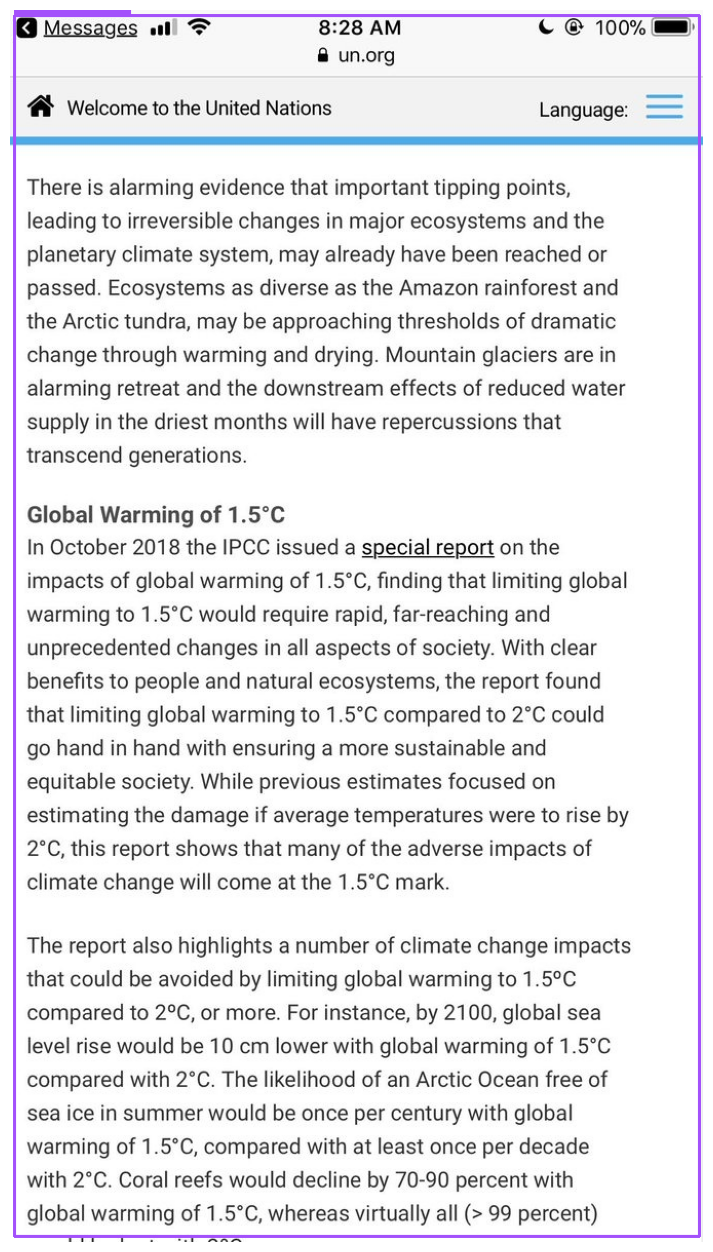

Person_count: 0


Similarities: 0.96043956, 0.8199624, 0.84015167
Similarities: 0.96043956, 0.8199624, 0.84015167
Average:  0.8735178311665853
Current Progress: 1

0: 416x640 (no detections), 130.5ms
Speed: 2.0ms preprocess, 130.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


tensor([[0.5001, 0.7889, 1.0000, 0.4217]])
tensor([0.3964])
['snow']


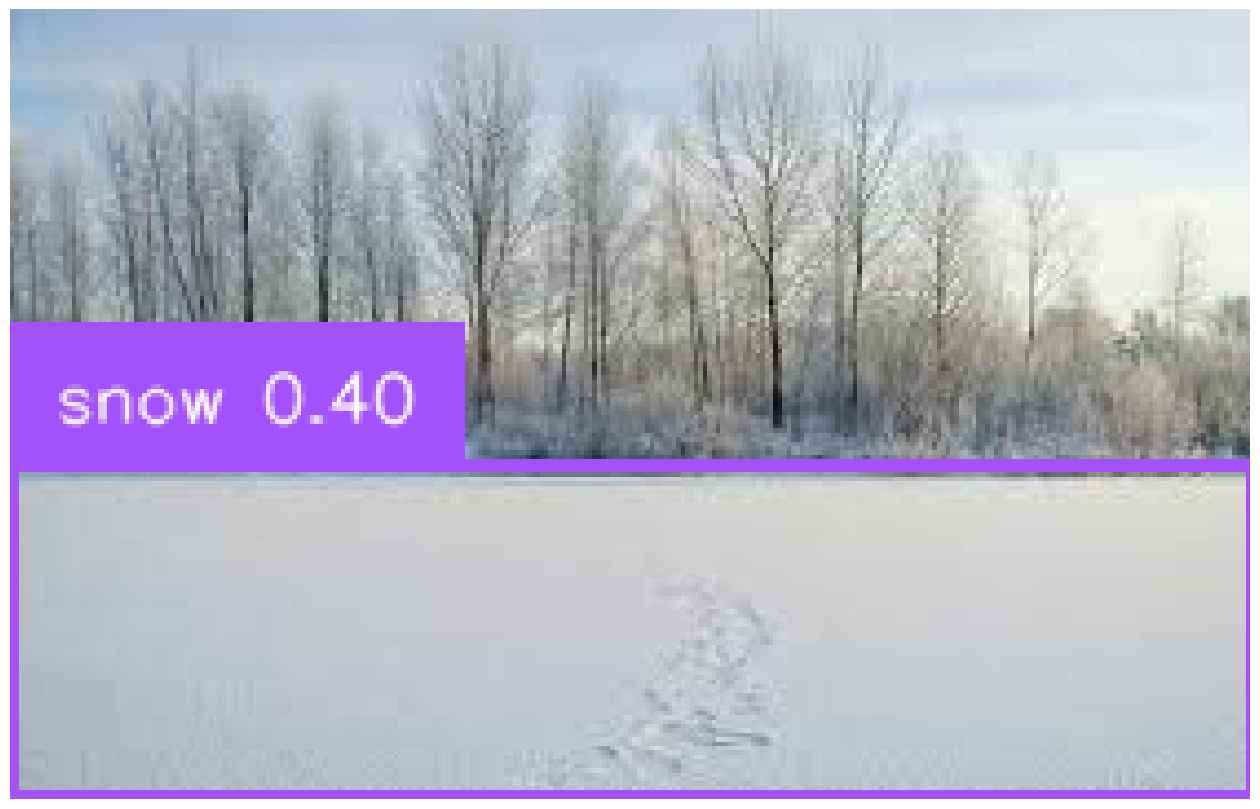

Person_count: 0


Similarities: 0.93199754, 0.83413255, 0.8501033
Similarities: 0.93199754, 0.83413255, 0.8501033
Average:  0.8720777829488119
Current Progress: 1

0: 480x640 1 bird, 129.6ms
Speed: 6.0ms preprocess, 129.6ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)


tensor([[0.5014, 0.4722, 0.2348, 0.3174]])
tensor([0.3776])
['glacier']


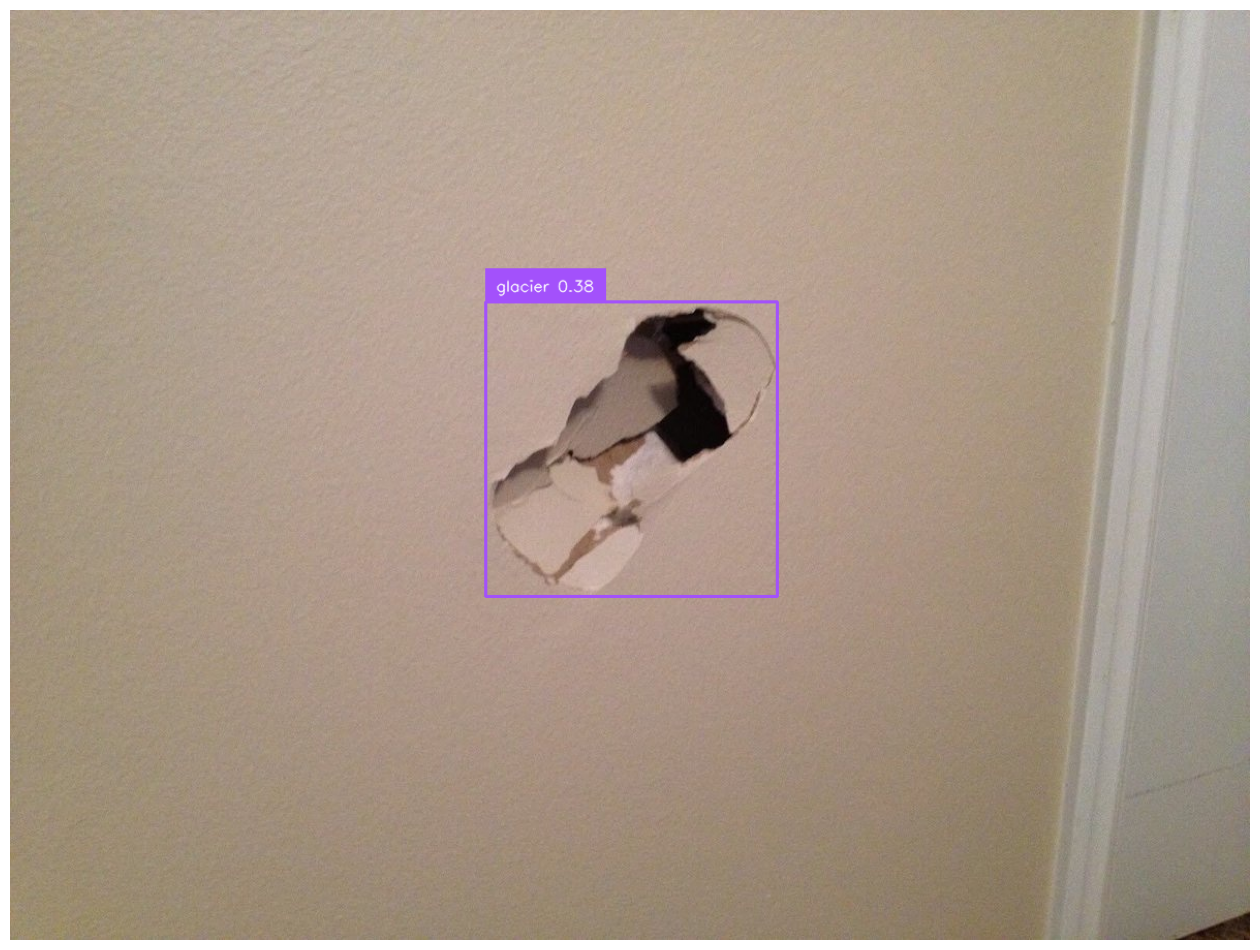

Person_count: 0


Similarities: 0.9622147, 0.8615202, 0.88565075
Similarities: 0.9622147, 0.8615202, 0.88565075
Average:  0.9031285444895426
Current Progress: 1

0: 640x608 1 person, 146.2ms
Speed: 4.0ms preprocess, 146.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 608)


tensor([[0.5593, 0.5544, 0.4794, 0.5774]])
tensor([0.5002])
['person']


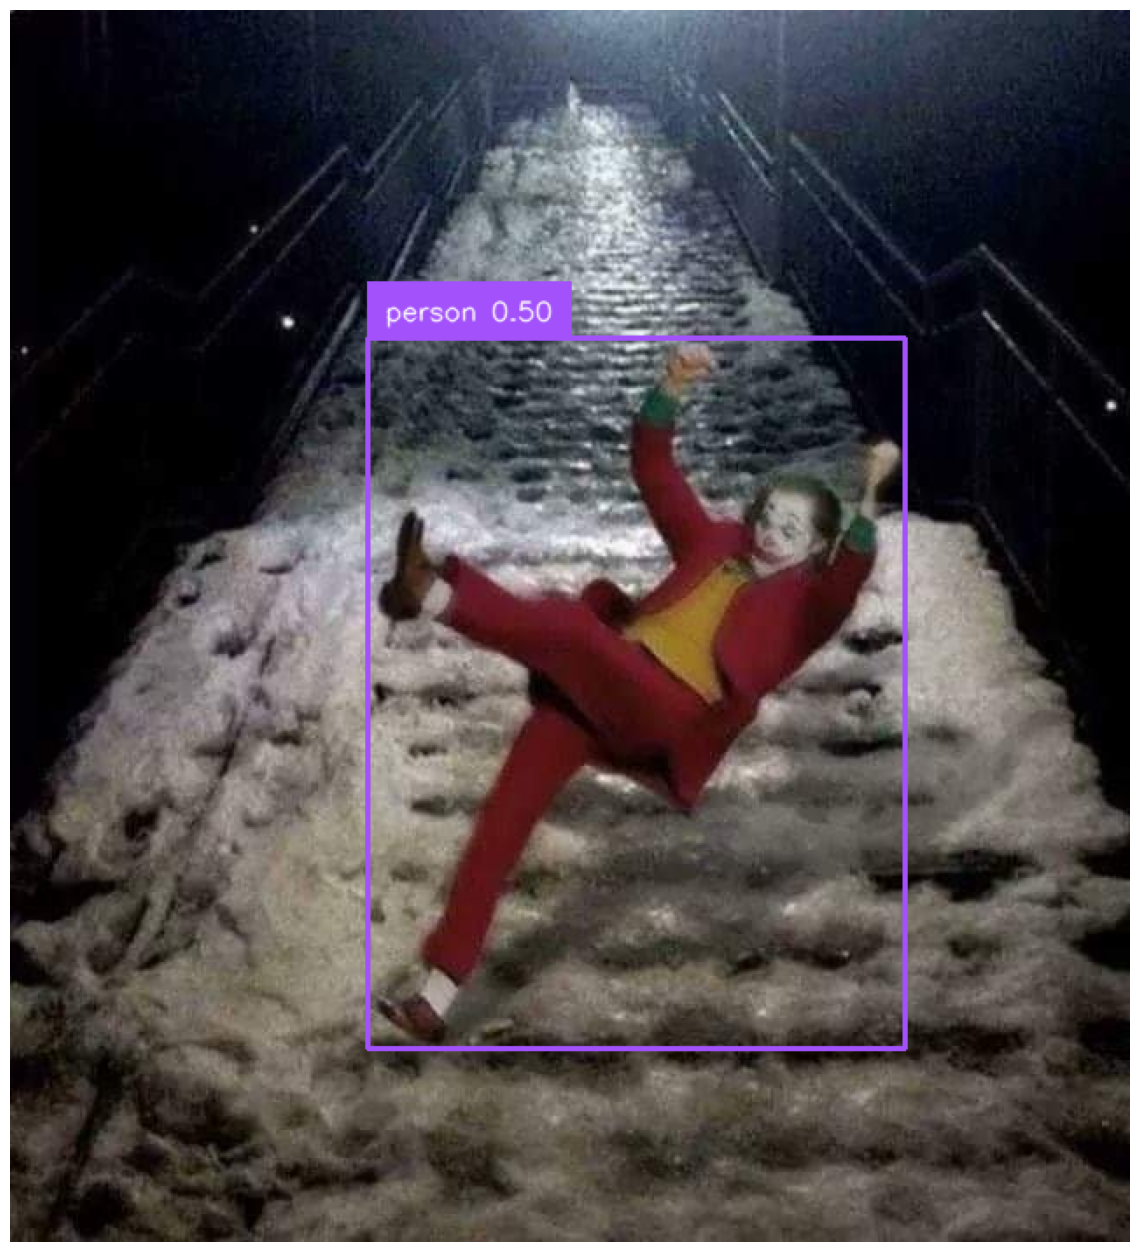

Person_count: 1
Predicted label:  disgust


In [2]:
## Write into .csv file id_1196710509485187074_2019-11-19.jpg
import json
import torchvision.transforms as transforms
import torchvision
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, AutoImageProcessor, AutoModelForImageClassification
from transformers import pipeline
from sklearn.metrics import pairwise
from PIL import Image
from ultralytics import YOLO
import cv2
from openpyxl import Workbook
from groundingdino.util.inference import load_model, load_image, predict, annotate
import supervision as sv

wb = Workbook()
ws = wb.active

image_data = df["img_name"].tolist()

header = ["image_name", "object_detection_results", "aisak_description", "moondream_description", "gemini_description","facial_emotion", "text_similarity_semantic", "text_similarity_semantic_expression", "labels", "bounding_boxes", "bounding_box_confidence"]
ws.append(header)

moondream_captions = {}
aisak_captions = {}
gemini_captions = {}
json_file_path = "C:\\Users\\Admin\\Documents\\GitHub\\Team_Project_ComputerVision\\captions\\gemini-captions.json"

with open(json_file_path, "r") as file:
    gemini_captions = json.load(file)


# Required lists and co
animals = ['bear', 'penguin', 'polar bear'] 

# Prerequisites for GroundingDINO
CONFIG_PATH = os.path.join("C:\\Users\\Admin\\", "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join("C:\\Users\\Admin\\GroundingDINO\\", "weights", WEIGHTS_NAME)

TEXT_PROMPT = "glacier, sign, map, cloud, diagram, mountain, snow, flag, hurricane, podium, building, visualization, bear, tree, person, plant, planet, bird, flower, dog, earth, planet, poster, iceberg, cyclone, fire, water, penguin, seal, bird, volcano, cat, car, tv, cow, bag, landscape, book, microphone, camera"
BOX_TRESHOLD = 0.37
TEXT_TRESHOLD = 0.37
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

# All Models so they are only loaded once
yolo_model = YOLO("yolov8n.pt").to(device)
emotion_processor = AutoImageProcessor.from_pretrained("Rajaram1996/FacialEmoRecog")
emotion_model = AutoModelForImageClassification.from_pretrained("Rajaram1996/FacialEmoRecog").to(device)
long_desc_model_id = "vikhyatk/moondream2"
long_desc_revision = "2024-04-02"
long_desc_model = AutoModelForCausalLM.from_pretrained(
    long_desc_model_id, trust_remote_code=True, revision=long_desc_revision
).to(device)
long_desc_tokenizer = AutoTokenizer.from_pretrained(long_desc_model_id, revision=long_desc_revision)
short_desc_pipeline = pipeline("image-to-text", model="aisak-ai/aisak-visual")
sbert_model = AutoModel.from_pretrained("Voicelab/sbert-base-cased-pl").to(device)
sbert_tokenizer = AutoTokenizer.from_pretrained("Voicelab/sbert-base-cased-pl")
dino_model = load_model(CONFIG_PATH, WEIGHTS_PATH).to(device)

i = 0 ### only temporary to test for some images and not all (locally)
for img_name in image_data: 
    labels = ""
    img_name = img_name.replace("\n","")
    image = Image.open(image_directory + img_name)
    image_source_dino, image_dino = load_image(image_directory + img_name)
    #image.show()
    results = yolo_model(image)
    names = yolo_model.names
    emotion = "---"
    
    boxes, logits, detected_objects = predict(
    model=dino_model, 
    image=image_dino, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
    )
    print(boxes)
    print(logits)
    
    annotated_frame = annotate(image_source=image_source_dino, boxes=boxes, logits=logits, phrases=detected_objects)
    print(detected_objects)

    %matplotlib inline  
    sv.plot_image(annotated_frame, (16, 16))
    i = 0
    for result in results:
        detections = result.pred[0] if hasattr(result, 'pred') else None  # Get the detected objects if available
        person_count = 0
        # Display the detected objects
        ids = result.boxes.cls
        for id in ids:
            name = names[int(id)]
            if (name == "person"):
                person_count += 1
        print("Person_count: " + str(person_count))
        if person_count >= 4:
            labels += "crowded"
        
        if (person_count >= 1):
            # Preprocess the image using the image processor
            inputs = emotion_processor(images=image, return_tensors="pt").to(device)
            
            # Get the predicted logits from the model
            outputs = emotion_model(**inputs)
            emotion_logits = outputs.logits

            # Get the predicted label index
            predicted_label = emotion_logits.argmax(dim=-1).item()

            # Get the predicted label name using the model's config
            emotion = emotion_model.config.id2label[predicted_label]

            # Print the predicted label
            print("Predicted label: ", emotion)
                        
    
    # long description model
    enc_image = long_desc_model.encode_image(image).to(device)
    moonDreamResult = long_desc_model.answer_question(enc_image, "Describe this image.", long_desc_tokenizer)
    moondream_captions[img_name] = moonDreamResult
    
    # short description model
    aisakResult = short_desc_pipeline(image)
    aisak_captions[img_name] = aisakResult
    
    # gemini description
    geminiResult = gemini_captions[img_name]
    
    object_string = ''
    for index, object in enumerate(detected_objects):
        if (index == len(detected_objects) - 1):
            object_string += object
        else:
            object_string += object + ','
    
    mapEntry = aisakResult[0]
    aisakResult = next(iter(mapEntry.values()))
    
    ### Comparison of the models ###
    tokens = sbert_tokenizer([geminiResult, moonDreamResult, aisakResult], padding=True, truncation=True, return_tensors='pt').to(device)
    x = sbert_model(tokens["input_ids"], tokens["attention_mask"]).pooler_output
    similarity_matrix = pairwise.cosine_similarity(x.cpu().detach().numpy())
    similarities = [similarity_matrix[0, 1], similarity_matrix[0, 2], similarity_matrix[1, 2]]
    similarity_strings = ", ".join(str(sim) for sim in similarities)
    print("Similarities: " + similarity_strings)
    
    # Gemini Results are not available for NSFW pictures - that's why this exception to make sure - most analysis is on SFW pictures though
    avg_sim = 0
    if not geminiResult:
        avg_sim = similarity_matrix[1,2]
    else:
        avg_sim = (similarity_matrix[0, 1] + similarity_matrix[0, 2] + similarity_matrix[1, 2]) / 3
               
    print("Similarities: " + str(similarity_matrix[0,1]) + ", " + str(similarity_matrix[0,2]) + ", " + str(similarity_matrix[1,2]))
    print("Average: " , avg_sim)
    
    avg_sim_rating = ""
    if avg_sim < 0.88:
        avg_sim_rating = "low"
    elif avg_sim > 0.92:
        avg_sim_rating = "high"
    else:
        avg_sim_rating = "medium"
    
    boxes_array = tensor_to_array(boxes)
    logits_array = tensor_to_array(logits.data)
    boxes_string = ""
    logit_string = ""
    
    for index, coordinate in enumerate(boxes_array):
        if (index == len(boxes_array) - 1):
            boxes_string = boxes_string + str(coordinate)
        else:
            boxes_string = boxes_string + str(coordinate) + ","
        
    for index, value in enumerate(logits_array):
        if index == len(logits_array) - 1:
            logit_string += str(value)
        else:
            logit_string += str(value) + ", "


    data_row = [img_name, object_string, aisakResult, moonDreamResult, geminiResult, emotion, avg_sim, avg_sim_rating, labels, boxes_string, logit_string]
    
    
    ws.append(data_row)
    detected_objects.clear()
    i+=1
    print("Current Progress: " + str(i))
    if (i == 2):
        break
    
wb.save("result.xlsx")
